In [ ]:
%pip install accelerate
%pip install diffusers
%pip install datasets
%pip install torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
from diffusers import UNet2DConditionModel
N_classes = 10
N_models = 10
models = [None for i in range(N_models)]
path = 'drive/MyDrive/Models/10_model_mix/'
device = 'cuda'

for i in range(N_models):
  models[i] = UNet2DConditionModel.from_pretrained(path + 'model_dig_{}'.format(i), safe_serialization=True)
  models[i].to(device)



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from accelerate import notebook_launcher
from diffusers import ScoreSdeVeScheduler
import gc
noise_scheduler = ScoreSdeVeScheduler(num_train_timesteps=1000)


In [ ]:
import numpy as np
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t)

sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate
import torch.nn.functional as F
from torchdiffeq import odeint

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_models,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                label=0,
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape
  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    # emb = torch.zeros(bs, 1, config.feature_dim)
    hs = F.one_hot(torch.tensor([label] * batch_size), num_classes=N_classes)
    hs = hs[:, None, :].to(torch.float)
    hs = hs.to(device)

    with torch.no_grad():
        score = sum(score_model(sample, time_steps, encoder_hidden_states=hs).sample
                    for score_model in score_models) / len(score_models)
    # return score.cpu().numpy().reshape((-1,)).astype(np.float64)
    return score.reshape((-1,))


  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = torch.ones((shape[0],)).to(device) * t
    # g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    g = diffusion_coeff(torch.tensor(t))
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  first_step = 0.01
  # res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(),
  #                           rtol=rtol, atol=atol, method='RK45', first_step=first_step)
  times = torch.arange(1, 0, -eps).to(device)
  res = odeint(ode_func, init_x.reshape(-1), times)
  # print(f"Number of function evaluations: {res.nfev}")
  print(res)
  x = torch.tensor(res[-1], device=device).reshape(shape)

  return x

<ipython-input-5-8f500bc53f7d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)
<ipython-input-6-1af4a37e2677>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g = diffusion_coeff(torch.tensor(t))
<ipython-input-5-8f500bc53f7d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t)
<ipython-input-6-1af4a37e2677>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

tensor([[  2.7697,  -4.5467,  11.1611,  ..., -12.0684,   1.9153,  -0.6281],
        [  2.3150,  -3.8448,   9.4551,  ..., -10.3430,   1.5985,  -0.5871],
        [  1.9612,  -3.2652,   8.0401,  ...,  -8.8751,   1.3491,  -0.5341],
        ...,
        [  0.2843,  -0.5949,   1.4411,  ...,  -1.6925,   0.2050,  -0.1739],
        [  0.2722,  -0.5764,   1.3930,  ...,  -1.6390,   0.1972,  -0.1701],
        [  0.2631,  -0.5625,   1.3570,  ...,  -1.5990,   0.1914,  -0.1673]],
       device='cuda:0')


<ipython-input-6-1af4a37e2677>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(res[-1], device=device).reshape(shape)


tensor([[ 3.1357e+00,  7.5338e+00,  4.4922e+00,  ..., -6.7704e+00,
          8.1577e+00, -6.8452e+00],
        [ 2.7156e+00,  6.3660e+00,  3.8058e+00,  ..., -5.7474e+00,
          6.8982e+00, -5.8017e+00],
        [ 2.3438e+00,  5.3757e+00,  3.2245e+00,  ..., -4.8820e+00,
          5.8425e+00, -4.9372e+00],
        ...,
        [ 7.8917e-03,  8.7324e-03,  8.8169e-03,  ...,  9.8034e-03,
          7.2907e-03,  6.7572e-03],
        [ 7.4561e-03,  8.3236e-03,  8.4439e-03,  ...,  9.4136e-03,
          6.8762e-03,  6.3888e-03],
        [ 7.1096e-03,  8.0151e-03,  8.1583e-03,  ...,  9.1149e-03,
          6.5526e-03,  6.0945e-03]], device='cuda:0')


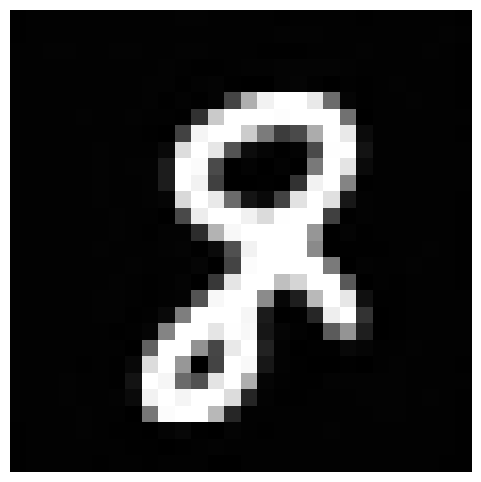

In [ ]:
from torchvision.utils import make_grid, save_image
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sample_batch_size = 1 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

N_samples = 10
start = 9
## Generate samples using the specified sampler.
# for label in range(start, N_classes):
label=8
for i in range(8, N_samples):
    samples = sampler(models,
                        marginal_prob_std_fn,
                        diffusion_coeff_fn,
                        sample_batch_size,
                        device=device,
                        label=label,
                        eps=.05)
    save_image(samples[0], '/content/drive/MyDrive/Models/Samples/10_model_mix/10_model_mix_{}_of_10_dig_{}.png'.format(i + 1, label))

## Sample visualization.


# file = open('test.png', 'w+')
# file.write(samples[0])
# file.close()

samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()
